# TODO
- remove reliance on rrow, like audio constants dict
- make into functions better
- show pinyin on top of character

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install gtts pydub audioop-lts
import time
import os
import pandas as pd
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip
from utils_data import (
    load_raw_data, check_dups, filter_df_to_vocab_of_interest, 
    fill_default_settings, delete_previous_attempt_files
    )
from utils_video import (
    combine_clips_with_audio_to_create_video, create_icon_from_slide,
    draw_word_index, draw_logo, draw_previous_word, draw_previous_sent,
    draw_vocab_based_on_format, generate_intro_slide,
    generate_word_list_slide, generate_outro_slide
)
from utils_audio import (
    create_tts_files_for_one_vocab_word, compute_pinyin_and_create_recordings,
    combine_audio_files_and_compute_durations,
    generate_nonvocab_audio_and_compute_durations, create_final_audio_from_each_word_and_nonvocab
)
from configs.v006_Mario import (
    data_settings, output_path,
    video_configs, icon_configs,
    nonvocab_slides, subtitle_text_configs,
    DEFAULT_TEXT_PROPERTIES,
)
subtitle_text_configs['font'] = ImageFont.truetype(subtitle_text_configs['font_name'], subtitle_text_configs['font_size'])
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130

In [3]:
truly_load_data = False
to_delete = False

# 0. Create dataframe of settings

In [4]:
# Create settings df
df_all_recordings_tomake = fill_default_settings(data_settings)
rrow = df_all_recordings_tomake.loc[0]

# Create folder for non-audio recordings for this project
project_artifacts_folder = f"{output_path}/{rrow['recording_name']}"

# Create folder if not exists, and delete previous files if desired
if not os.path.exists(project_artifacts_folder):
    os.mkdir(project_artifacts_folder)
if to_delete:
    delete_previous_attempt_files(project_artifacts_folder, to_delete=to_delete)
df_all_recordings_tomake

,recording_id,filename_suffix,min_priority,max_priority,categories2_allowed,types_allowed,min_known_english_prompt,max_known_english_prompt,min_known_pinyin_prompt,max_known_pinyin_prompt,sort_keys,sort_asc,min_combo_quality,categories_allowed,cat1_values_allowed,types_allowed_str,min_adu,min_per,min_date,contains_character,exclude_words,max_count,recording_name
0,ceword_csent,_mario,1,4,"[mario party, mario kart, mario character]","[combo, no combo, two word, prefix, single cha...",1,6,1,6,"[category1, category2, pinyin]","[True, True, True]",6,None,None,,1,1,2025-01-01,None,None,1000000,0928_ceword_csent__mario


# 1. Load data

In [5]:
if truly_load_data:
    df_all_vocab = load_raw_data()
    df_all_vocab.to_csv('latest_data.csv', index=False)
else:
    df_all_vocab = pd.read_csv('latest_data.csv')
    print('!!!!!!!! WARNING: not truly loading data !!!!!!!!')

df_dups = check_dups(df_all_vocab)
print(f'# duplicate vocab: {len(df_dups)}')
print(df_all_vocab.shape)
df_all_vocab.head(3)

!!!!!!!! WARNING: not truly loading data !!!!!!!!
# duplicate vocab: 2
(5387, 28)


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,1,房贷,fáng dài,mortgage,combo,1.0,1.0,1.0,2.0,NaN,life,NaN,1.0,房,house,贷,loan,NaN,NaN,NaN,NaN,他每个月都要还房贷,Ta měi gè yuè dōu yào huán fángdài,He has to pay his mortgage every month,2025-01-02,NaN,5.0,5.0
1,2,白天,bái tiān,daytime,combo,2.0,2.0,1.0,1.0,NaN,time,NaN,1.0,白,white,天,day,NaN,NaN,NaN,NaN,白天很热晚上比较凉快,Báitiān hěn rè wǎnshàng bǐjiào liángkuai,It is hot in the daytime and cooler at night,2025-01-02,NaN,5.0,5.0
2,3,组成,zǔ chéng,to form;make up,combo,3.0,5.0,5.0,5.0,NaN,general,NaN,3.0,组,set,成,become,NaN,NaN,NaN,NaN,水是由氢和氧组成的,Shuǐ shì yóu qīng hé yǎng zǔchéng de,Water is made up of hydrogen and oxygen,2025-01-02,NaN,5.0,5.0


# 2. Select data

In [6]:
dfs_vocab_lists = {}
n_vocab_by_recording = {}
dfs_vocab_lists[rrow['recording_name']] = filter_df_to_vocab_of_interest(df_all_vocab, rrow)
n_vocab_by_recording[rrow['recording_name']] = len(dfs_vocab_lists[rrow['recording_name']])
print(rrow['recording_name'], n_vocab_by_recording[rrow['recording_name']])

dfs_vocab_lists[rrow['recording_name']].head(3)

0928_ceword_csent__mario 43


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,5160,碧琪公主,bì qí gōng zhǔ,Princess Peach,proper noun,3.0,5.0,5.0,5.0,NaN,game,mario character,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,碧琪公主使用了一个道具,bì qí gōng zhǔ shǐ yòng le yī gè dào jù,Princess Peach used an item,2025-09-09,chatgpt,2.0,5.0
1,5170,大金刚,dà jīn gāng,Donkey Kong,proper noun,2.0,5.0,5.0,5.0,NaN,game,mario character,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,大金刚掷出了最大的骰子,dà jīn gāng zhì chū le zuì dà de tóu zi,Donkey Kong rolled the biggest dice,2025-09-09,chatgpt,2.0,5.0
2,5161,黛西,dài xī,Daisy,proper noun,3.0,5.0,5.0,5.0,NaN,game,mario character,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,黛西加入了派对,dài xī jiā rù le pài duì,Daisy joined the party,2025-09-09,chatgpt,2.0,5.0


# 3. Create vocabulary audio recordings

In [7]:
if rrow['recording_id'] == '005':
    dfs_vocab_lists[rrow['recording_name']] = compute_pinyin_and_create_recordings(dfs_vocab_lists[rrow['recording_name']])
for i_row, row in dfs_vocab_lists[rrow['recording_name']].iterrows():
    print(f'{rrow['recording_name']} row{i_row}')
    create_tts_files_for_one_vocab_word(row, rrow)

0928_ceword_csent__mario row0
0.002s, ALREADY EXISTS, zh, 碧琪公主
0.001s, ALREADY EXISTS, zh_slow, 碧琪公主
0.000s, ALREADY EXISTS, english, Princess Peach
0.001s, ALREADY EXISTS, zh, 碧琪公主使用了一个道具
0928_ceword_csent__mario row1
0.002s, ALREADY EXISTS, zh, 大金刚
0.002s, ALREADY EXISTS, zh_slow, 大金刚
0.000s, ALREADY EXISTS, english, Donkey Kong
0.002s, ALREADY EXISTS, zh, 大金刚掷出了最大的骰子
0928_ceword_csent__mario row2
0.000s, ALREADY EXISTS, zh, 黛西
0.002s, ALREADY EXISTS, zh_slow, 黛西
0.000s, ALREADY EXISTS, english, Daisy
0.002s, ALREADY EXISTS, zh, 黛西加入了派对
0928_ceword_csent__mario row3
0.000s, ALREADY EXISTS, zh, 库巴
0.008s, ALREADY EXISTS, zh_slow, 库巴
0.000s, ALREADY EXISTS, english, Bowser
0.000s, ALREADY EXISTS, zh, 库巴出现并要求你付金币
0928_ceword_csent__mario row4
0.000s, ALREADY EXISTS, zh, 库巴兵
0.000s, ALREADY EXISTS, zh_slow, 库巴兵
0.000s, ALREADY EXISTS, english, Koopa Troopa
0.000s, ALREADY EXISTS, zh, 库巴兵为你加油
0928_ceword_csent__mario row5
0.000s, ALREADY EXISTS, zh, 罗莎塔娜
0.000s, ALREADY EXISTS, zh_slow, 罗

## 3b. Compute durations of combined audios for each vocab word

In [8]:
df_vocab_audio_durations = {}
audio_duration_file_name = f"{project_artifacts_folder}/audio_durations_vocab_only.csv"
if os.path.exists(audio_duration_file_name):
    df_vocab_audio_durations[rrow['recording_name']] = pd.read_csv(audio_duration_file_name)
    print(f"Loaded existing audio durations for {rrow['recording_name']}, shape {df_vocab_audio_durations[rrow['recording_name']].shape}")
else:
    df_vocab_audio_durations[rrow['recording_name']] = combine_audio_files_and_compute_durations(dfs_vocab_lists[rrow['recording_name']], rrow)
    df_vocab_audio_durations[rrow['recording_name']].to_csv(audio_duration_file_name, index=False)

df_vocab_audio_durations[rrow['recording_name']]['nonvocab_file_path'] = None
df_vocab_audio_durations[rrow['recording_name']]['nonvocab_pause_ms'] = None
df_vocab_audio_durations[rrow['recording_name']]['nonvocab_key'] = None
print(f"Total duration: {df_vocab_audio_durations[rrow['recording_name']]['combined'].sum()}s")
df_vocab_audio_durations[rrow['recording_name']].head(3)

0.43 seconds, recid0928_ceword_csent__mario, row 0, 碧琪公主
0.36 seconds, recid0928_ceword_csent__mario, row 1, 大金刚
0.36 seconds, recid0928_ceword_csent__mario, row 2, 黛西
0.37 seconds, recid0928_ceword_csent__mario, row 3, 库巴
0.36 seconds, recid0928_ceword_csent__mario, row 4, 库巴兵
0.36 seconds, recid0928_ceword_csent__mario, row 5, 罗莎塔娜
0.36 seconds, recid0928_ceword_csent__mario, row 6, 栗宝宝
0.36 seconds, recid0928_ceword_csent__mario, row 7, 路易吉
0.35 seconds, recid0928_ceword_csent__mario, row 8, 蒙面鬼
0.36 seconds, recid0928_ceword_csent__mario, row 9, 马里奥
0.36 seconds, recid0928_ceword_csent__mario, row 10, 奇诺比奥
0.36 seconds, recid0928_ceword_csent__mario, row 11, 瓦路易吉
0.36 seconds, recid0928_ceword_csent__mario, row 12, 瓦里奥
0.36 seconds, recid0928_ceword_csent__mario, row 13, 小库巴
0.35 seconds, recid0928_ceword_csent__mario, row 14, 耀西
0.36 seconds, recid0928_ceword_csent__mario, row 15, 炸弹兵
0.36 seconds, recid0928_ceword_csent__mario, row 16, 大奖赛
0.35 seconds, recid0928_ceword_csent__ma

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_chinese,d_english,d_sent,rel_start_chinese,rel_start_english,rel_start_sent,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key
0,碧琪公主,bì qí gōng zhǔ,Princess Peach,碧琪公主使用了一个道具,bì qí gōng zhǔ shǐ yòng le yī gè dào jù,Princess Peach used an item,1.632,1.536,3.312,0,2.132,4.168,8.480,8.479667,None,None,None
1,大金刚,dà jīn gāng,Donkey Kong,大金刚掷出了最大的骰子,dà jīn gāng zhì chū le zuì dà de tóu zi,Donkey Kong rolled the biggest dice,1.296,1.272,3.336,0,1.796,3.568,7.904,7.903667,None,None,None
2,黛西,dài xī,Daisy,黛西加入了派对,dài xī jiā rù le pài duì,Daisy joined the party,1.176,0.912,2.496,0,1.676,3.088,6.584,6.583667,None,None,None


# 4. Create non-vocab audio recordings

In [10]:
audio_filler_variables = {}
df_vocab_audio_durations, audio_filler_variables, nonvocab_slides = generate_nonvocab_audio_and_compute_durations(
    rrow, audio_filler_variables, df_vocab_audio_durations, nonvocab_slides, output_path)
df_vocab_audio_durations[rrow['recording_name']].head(10)

Generated 欢迎观看我的普通话数据库视频 6: 马里奥词汇: 附例句
Generated 这些是将在接下来的5分钟内复习的43个单词
Generated 如果你有任何问题、建议或反馈，请留言。请点赞并订阅。


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_chinese,d_english,d_sent,rel_start_chinese,rel_start_english,rel_start_sent,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 6: 马里奥词汇: 附例句,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.560000,output/videos//0928_ceword_csent__mario/欢迎观看我的...,500,intro,8.560000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的5分钟内复习的43个单词,Zhèxiē shì jiàng zài jiē xiàlái de 5 fēnzhōng ...,These are the 43 words that will be reviewed o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.100000,output/videos//0928_ceword_csent__mario/这些是将在接...,500,word_list,15.660000,8.560000,NaN,NaN,NaN
2,碧琪公主,bì qí gōng zhǔ,Princess Peach,碧琪公主使用了一个道具,bì qí gōng zhǔ shǐ yòng le yī gè dào jù,Princess Peach used an item,1.632,1.536,3.312,0.0,2.132,4.168,8.480,8.479667,None,None,None,24.139667,15.660000,17.792000,15.660000,19.828000
3,大金刚,dà jīn gāng,Donkey Kong,大金刚掷出了最大的骰子,dà jīn gāng zhì chū le zuì dà de tóu zi,Donkey Kong rolled the biggest dice,1.296,1.272,3.336,0.0,1.796,3.568,7.904,7.903667,None,None,None,32.043333,24.139667,25.935667,24.139667,27.707667
4,黛西,dài xī,Daisy,黛西加入了派对,dài xī jiā rù le pài duì,Daisy joined the party,1.176,0.912,2.496,0.0,1.676,3.088,6.584,6.583667,None,None,None,38.627000,32.043333,33.719333,32.043333,35.131333
5,库巴,kù bā,Bowser,库巴出现并要求你付金币,kù bā chū xiàn bìng yāo qiú nǐ fù jīn bì,Bowser appeared and demanded coins,1.104,0.984,3.648,0.0,1.604,3.088,7.736,7.735667,None,None,None,46.362667,38.627000,40.231000,38.627000,41.715000
6,库巴兵,kù bā bīng,Koopa Troopa,库巴兵为你加油,kù bā bīng wèi nǐ jiā yóu,Koopa Troopa is cheering for you,1.368,1.272,2.640,0.0,1.868,3.640,7.280,7.279667,None,None,None,53.642333,46.362667,48.230667,46.362667,50.002667
7,罗莎塔娜,luó shā tǎ nà,Rosalina,罗莎塔娜用魔法帮助了你,luó shā tǎ nà yòng mó fǎ bāng zhù le nǐ,Rosalina helped you with her magic,1.656,1.128,3.576,0.0,2.156,3.784,8.360,8.359667,None,None,None,62.002000,53.642333,55.798333,53.642333,57.426333
8,栗宝宝,lì bǎo bǎo,Goomba,栗宝宝加入了这场派对,lì bǎo bǎo jiā rù le zhè chǎng pài duì,Goomba joined this party,1.320,0.816,3.144,0.0,1.820,3.136,7.280,7.279667,None,None,None,69.281667,62.002000,63.822000,62.002000,65.138000
9,路易吉,lù yì jí,Luigi,路易吉获得了一颗星星,lù yì jí huò dé le yī kē xīng xīng,Luigi collected a star,1.368,1.104,3.144,0.0,1.868,3.472,7.616,7.615667,None,None,None,76.897333,69.281667,71.149667,69.281667,72.753667


# 5. Combine individual vocab into final audio recording

In [11]:
for _, rrow in df_all_recordings_tomake.iterrows():
    create_final_audio_from_each_word_and_nonvocab(rrow, df_vocab_audio_durations, output_path)

4.53s, output/videos/0928_ceword_csent__mario/audio.mp3


# 6. Create images for video

In [12]:
# If don't want to rerun the above cells, then just run this cell to load the audio durations
audio_generation_previous_run = True
if audio_generation_previous_run:
    df_audio_durations = {}
    try:
        df_audio_durations[rrow['recording_name']] = pd.read_csv(f"{project_artifacts_folder}/audio_durations_all.csv")
        print(f"{rrow['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {rrow['recording_name']}, please run the cell above to generate audio durations.")
else:
    df_audio_durations = df_vocab_audio_durations
df_audio_durations[rrow['recording_name']].head()

0928_ceword_csent__mario loaded


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_chinese,d_english,d_sent,rel_start_chinese,rel_start_english,rel_start_sent,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 6: 马里奥词汇: 附例句,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.560000,output/videos//0928_ceword_csent__mario/欢迎观看我的...,500.0,intro,8.560000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的5分钟内复习的43个单词,Zhèxiē shì jiàng zài jiē xiàlái de 5 fēnzhōng ...,These are the 43 words that will be reviewed o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.100000,output/videos//0928_ceword_csent__mario/这些是将在接...,500.0,word_list,15.660000,8.560000,NaN,NaN,NaN
2,碧琪公主,bì qí gōng zhǔ,Princess Peach,碧琪公主使用了一个道具,bì qí gōng zhǔ shǐ yòng le yī gè dào jù,Princess Peach used an item,1.632,1.536,3.312,0.0,2.132,4.168,8.480,8.479667,NaN,NaN,NaN,24.139667,15.660000,17.792000,15.660000,19.828000
3,大金刚,dà jīn gāng,Donkey Kong,大金刚掷出了最大的骰子,dà jīn gāng zhì chū le zuì dà de tóu zi,Donkey Kong rolled the biggest dice,1.296,1.272,3.336,0.0,1.796,3.568,7.904,7.903667,NaN,NaN,NaN,32.043333,24.139667,25.935667,24.139667,27.707667
4,黛西,dài xī,Daisy,黛西加入了派对,dài xī jiā rù le pài duì,Daisy joined the party,1.176,0.912,2.496,0.0,1.676,3.088,6.584,6.583667,NaN,NaN,NaN,38.627000,32.043333,33.719333,32.043333,35.131333


## 6a. Vocab words

Drawing 0: 碧琪公主
Drawing 1: 大金刚
Drawing 2: 黛西
Drawing 3: 库巴
Drawing 4: 库巴兵
Drawing 5: 罗莎塔娜
Drawing 6: 栗宝宝
Drawing 7: 路易吉
Drawing 8: 蒙面鬼
Drawing 9: 马里奥
Drawing 10: 奇诺比奥
Drawing 11: 瓦路易吉
Drawing 12: 瓦里奥
Drawing 13: 小库巴
Drawing 14: 耀西
Drawing 15: 炸弹兵
Drawing 16: 大奖赛
Drawing 17: 第一名
Drawing 18: 龟壳
Drawing 19: 捷径
Drawing 20: 加速
Drawing 21: 减速
Drawing 22: 蘑菇
Drawing 23: 马里奥赛车
Drawing 24: 赛道
Drawing 25: 赛圈
Drawing 26: 三连蘑菇
Drawing 27: 最后一名
Drawing 28: 对战
Drawing 29: 道具
Drawing 30: 规则
Drawing 31: 格子
Drawing 32: 回合
Drawing 33: 交换
Drawing 34: 积分
Drawing 35: 金币
Drawing 36: 马里奥派对
Drawing 37: 棋盘
Drawing 38: 骰子
Drawing 39: 陷阱
Drawing 40: 小游戏
Drawing 41: 星星
Drawing 42: 一对三



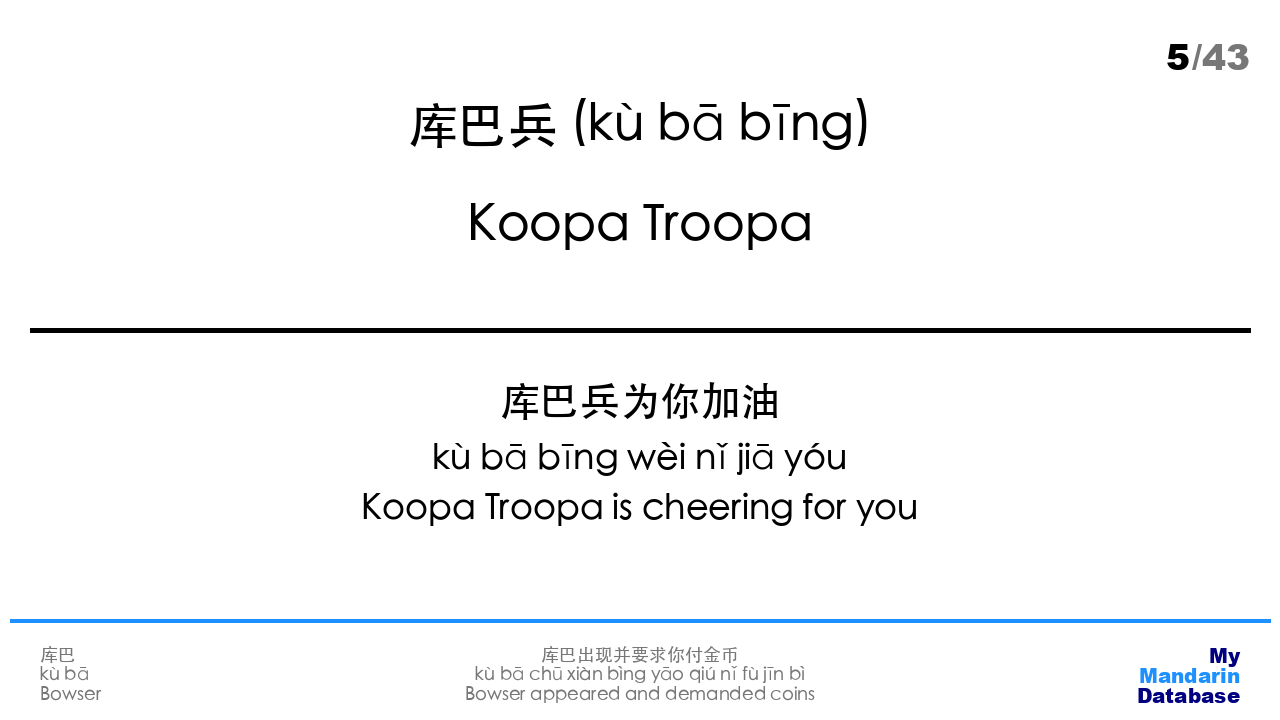

In [17]:
# Overall initializations
clips = []
previous_word = ''
previous_sent = ''

# Create folder to hold slide images
slides_path = f"{output_path}/{rrow['recording_name']}/slides"
if not os.path.exists(slides_path):
    os.mkdir(slides_path)

# Fill in defaults for any missing properties
for config_key, default_config_value in DEFAULT_TEXT_PROPERTIES.items():
    for vocab_slide_id, vocab_slide_settings in video_configs['vocab_slide'].items():
        if config_key not in vocab_slide_settings.keys():
            video_configs['vocab_slide'][vocab_slide_id][config_key] = default_config_value

# Iterate through each word
df_audio_durations_words_only = df_audio_durations[rrow['recording_name']].dropna(subset='sum_theory').reset_index(drop=True)
for word_idx, row in df_audio_durations_words_only.iterrows():
    # Initialize image
    print(f'Drawing {word_idx}: {row["chinese"]}')
    current_image_file_path = f"{slides_path}/{row['chinese']}"
    img = Image.new("RGB", video_configs['bg_size'], color=video_configs['bg_color'])
    draw = ImageDraw.Draw(img)
    
    # Header/Footer texts
    draw_word_index(draw, video_configs, n_vocab_by_recording[rrow['recording_name']], word_idx)
    draw_logo(draw, video_configs)
    draw_previous_word(draw, video_configs, previous_word)
    draw_previous_sent(draw, video_configs, previous_sent)
    draw.line([
        (video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y']),
        (video_configs['bg_size'][0] - video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y'])],
        fill=video_configs['footer_line']['color'],
        width=video_configs['footer_line']['width'],
        joint=None)
    
    # Update previous
    previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"
    if rrow['recording_id'] in ['013', 'ceword_csent']:
        previous_sent = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"

    # Draw vocab depending on recording ID
    draw_vocab_based_on_format(rrow['recording_id'], row, video_configs, current_image_file_path, img, draw, clips)

clips[14].display_in_notebook()

# 7. Create non-vocab slides


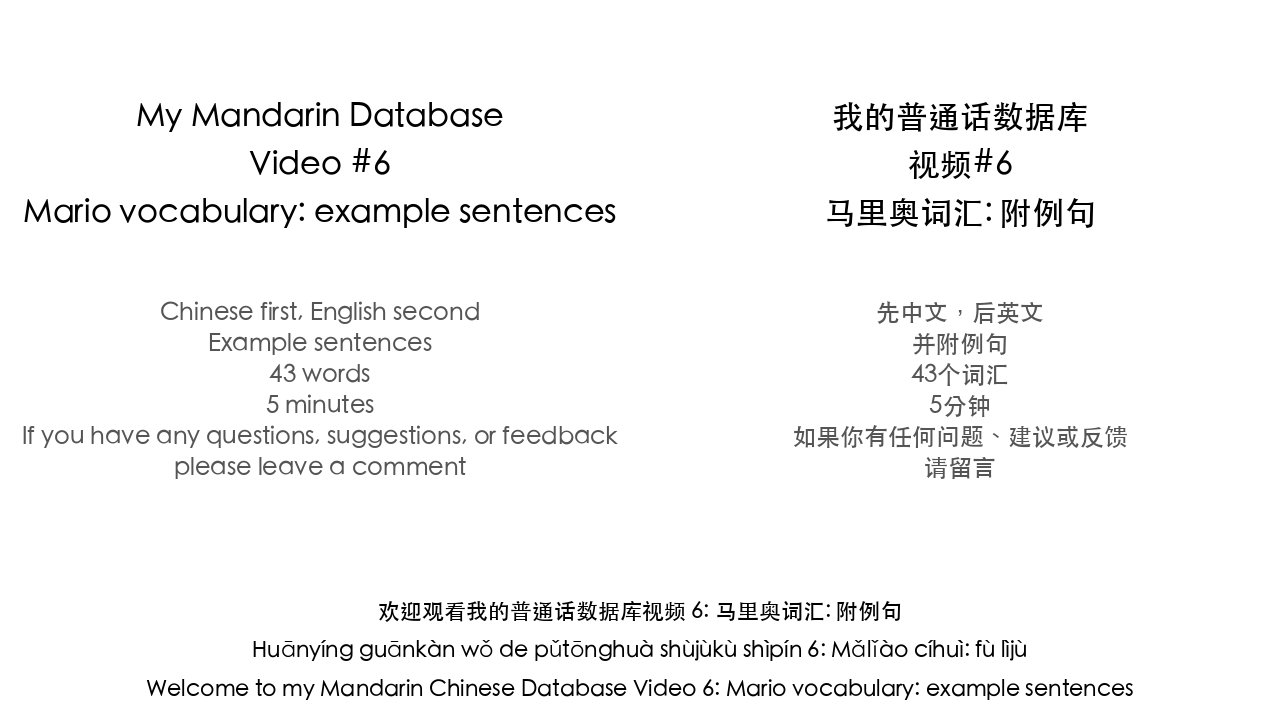

In [14]:
if 'intro' in nonvocab_slides.keys():
    img = generate_intro_slide(video_configs, nonvocab_slides['intro'], subtitle_text_configs, audio_filler_variables[rrow['recording_name']])
    img.save(f"{project_artifacts_folder}/intro.png")
my_img = ImageClip(f"{project_artifacts_folder}/intro.png", duration=1).with_start(0)
my_img.display_in_notebook()


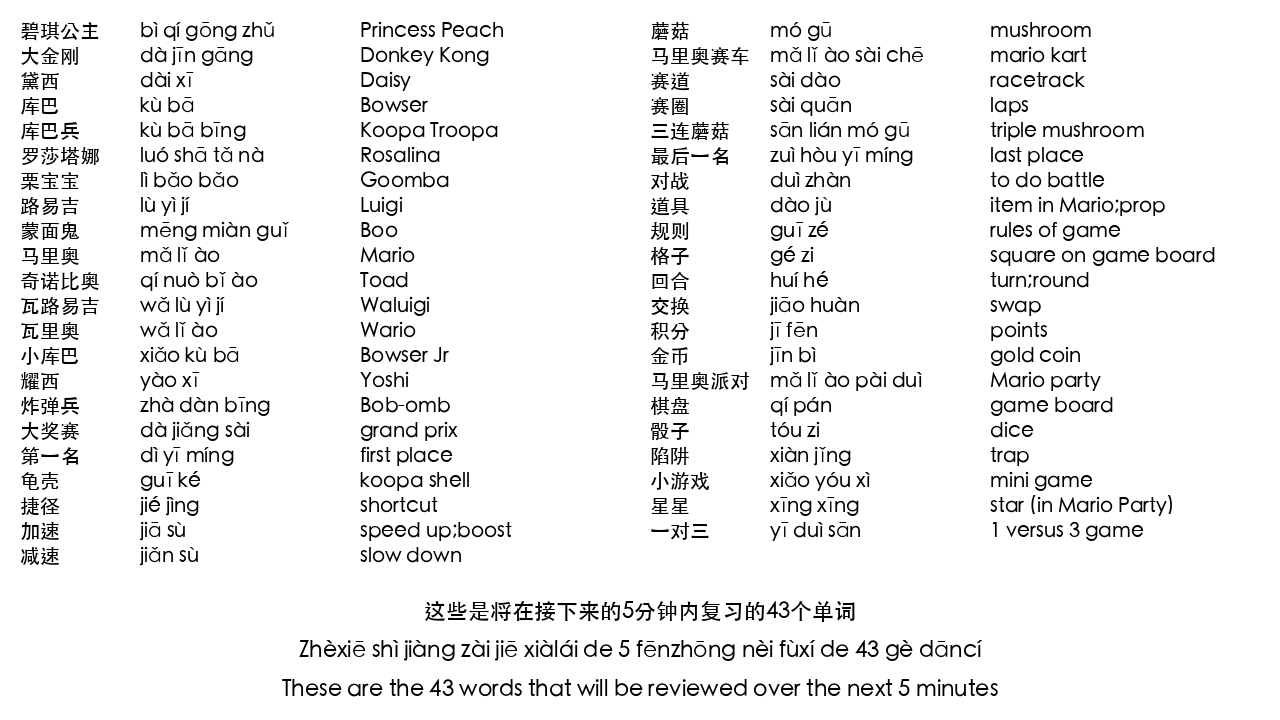

In [18]:
if 'word_list' in nonvocab_slides.keys():
    img = generate_word_list_slide(video_configs, nonvocab_slides['word_list'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/word_list.png")
my_img = ImageClip(f"{project_artifacts_folder}/word_list.png", duration=1).with_start(0)
my_img.display_in_notebook()


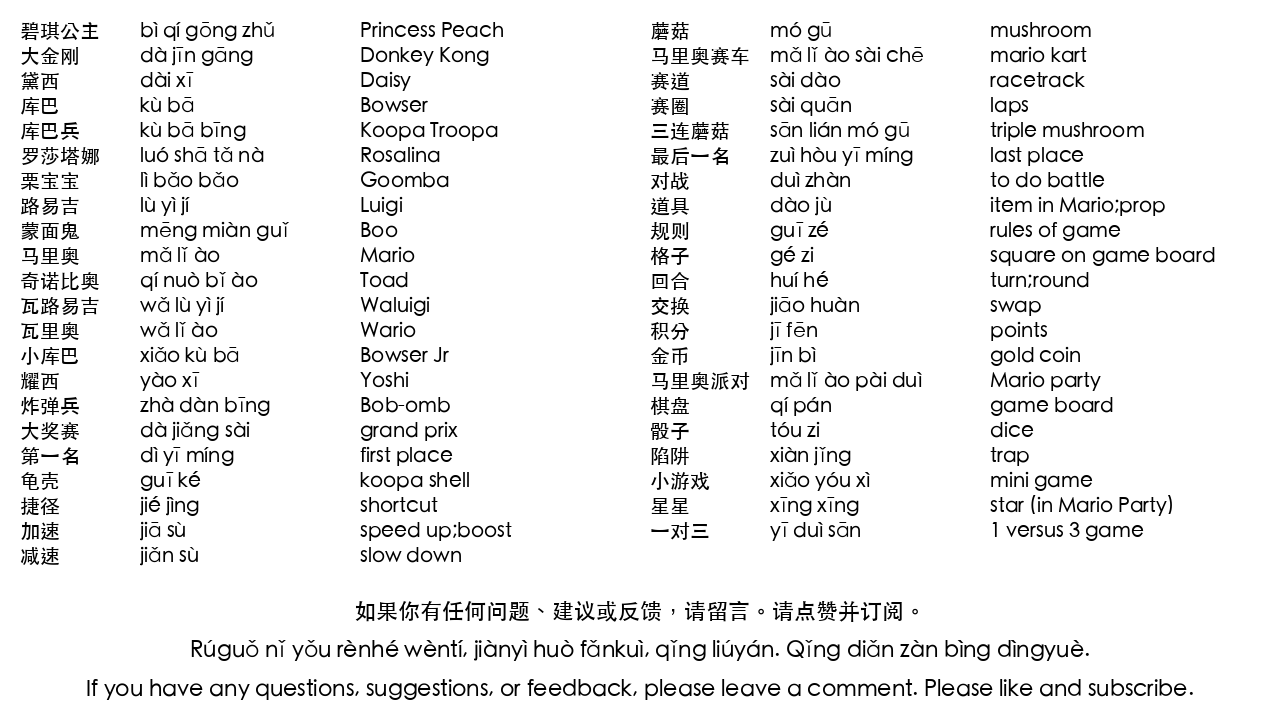

In [19]:
if 'outro' in nonvocab_slides.keys():
    img = generate_outro_slide(video_configs, nonvocab_slides['outro'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/outro.png")
my_img = ImageClip(f"{project_artifacts_folder}/outro.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 8. Create video icon


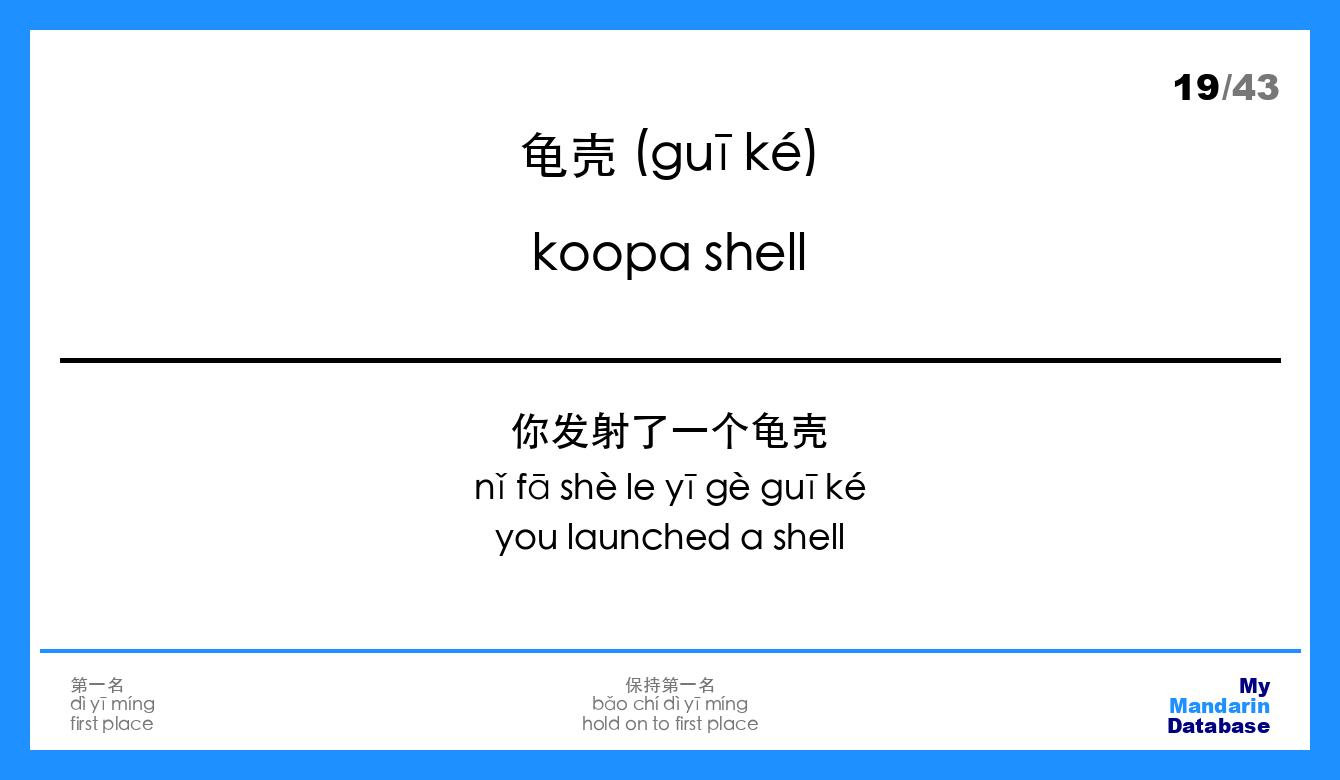

In [20]:
img = create_icon_from_slide(icon_configs, video_configs, project_artifacts_folder)
img.save(f'{project_artifacts_folder}/icon.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 9. Create video

In [21]:
combine_clips_with_audio_to_create_video(clips, nonvocab_slides, project_artifacts_folder)

Number of clips: 132
audio: 349.060s, video: 348.990s; difference: 0.070s
MoviePy - Building video output/videos//0928_ceword_csent__mario/video.mp4.
MoviePy - Writing audio in videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video output/videos//0928_ceword_csent__mario/video.mp4



MoviePy - Done !
MoviePy - video ready output/videos//0928_ceword_csent__mario/video.mp4
